# Birth Order Classification
#### CHAPTER 04: _Fundamentals of Feature Importance and Impact_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt
The objective of this study is to find which features (whether quiz answers, technical, and demographical details) explain the birth order.
One way to do this is by creating classification models to predict birth order, and then doing the following:
- Feature importance: a global modular interpretation method that uses the model's intrinsic parameters to discover which features impact the model the most
- Feature importance with a more reliable method: the Permutation-based Feature Importance (PFI)
- Examining the marginal impact of the most important features to the outcome using Partial Dependency Plots (PDPs); they identify which feature values correlate the most with the predictions
- Getting a granular visualization of how individual features impact the model's predictions with Individual Conditional Expectation (ICE) plots

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [1]:
# !pip install --upgrade pandas numpy scikit-learn matplotlib

Install these if running on Google Colab or ***not already installed***:

In [2]:
# !pip install git+https://github.com/SauceCat/PDPbox.git
# !pip install --upgrade pycebox

### Loading the Libraries

In [3]:
import math
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, discriminant_analysis, ensemble, neural_network, inspection
import matplotlib.pyplot as plt
from pdpbox import pdp
from pycebox.ice import ice, ice_plot

### Understanding and Preparing the Data

In [4]:
birthorder_df = pd.read_csv("./FBPS-ValidationData/FBPS-ValidationData.csv", delimiter='\t')
# filter the dataset on the following countries: 
# the United states of america, canada, the united kingdom, Australia, Ireland, and New Zealand
birthorder_df = birthorder_df[birthorder_df.country.isin(['US', 'GB', 'CA', 'AU', 'IE', 'NZ'])]
birthorder_df.reset_index(inplace=True)
# drop all datatime columns and the index colum
birthorder_df.drop(['submittime', 'dateload','index'],axis=1, inplace=True)

In [5]:
birthorder_df.shape

(29820, 87)

In this dataframe, there is 97 columns. Detailed explanation about these columns can be found in the FBPS-ValidationData-Codebook.txt file located on https://www.kaggle.com/datasets/lucasgreenwell/firstborn-personality-scale-responses . <br>
Let us review the columns: <br>
- The physiological features:
  - Q1, ..., Q26: type: ordinal, answers to 26 birth-order research questions, based on a 5-point Likert scale, i.e., 0=no answer, 1=disagree, 3=neutral, 5=agree
  - EXT1, ..., EXT10, EST1, ..., EST10, AGR1, ..., AGR10, CSN1, ..., CSN10, OPN1, ..., OPN10: type: Ordinal, the International Personality Item Pool (IPIP) Big Five questionnaire. It is made of 50 questions following the 5-point Likert scale
- The demographic features:
  - age: type: ordinal, in years
  - engnat: type: binary, whether English is the native language of the participant, 1=yes and 2=no
  - gender: type: categorical, gender: male, female, other, undefined
  - birthn: type: ordinal, total number of children 
  - country: type: categorical, the participant's country
  - birthpos: type: ordinal, 1=firstborn, 2=middle child, 3=lastborn
- The technical features:
  - source: type: categorical, how the user got to the personality test, 1=directly from google, 2=front page of website, 3=any other
  - screensize: type: ordinal, ```2= >600 pixels```, ```1= <600 px```
  - introelapse: type: continuous, time spent on the personality test landing page in seconds
  - testelapse: type: continuous, time spent on the personality test main body in seconds
  - endlapse: type: continuous, time spent on the personality test exit page in seconds

The number of features described here are 87 not 97, that is because the 3 categorical features (gender, country, and source) are already encoded using one-hot-encoding. <br>

*One-hot encoding of categorical features creates individual features for each category so they are represented in the ML model, adding expressiveness and Accuracy. It allows us to interpret them independently.*

In [6]:
# One hot encode the categorical variables
birthorder_df = pd.get_dummies(birthorder_df, columns = ['country', 'source', 'gender'])

In [7]:
new_column=[]
for i in range(len(birthorder_df)):
    order = birthorder_df['birthpos'][i]
    nbr_of_children = birthorder_df['birthn'][i]
    if order ==1:
        new_column.append(order) # this is the first child
    elif order == nbr_of_children: 
        new_column.append(3)# this is the last child
    else:
        new_column.append(2)# else this is a middle child
birthorder_df['birthpos']= new_column

In [8]:
birthorder_df.shape

(29820, 97)

#### Data Preparation
split the dataset into train (67\%) & test sets.

In [9]:
# The important thing is not to set the model, but to get the features importance

In [10]:
rand = 9
y = birthorder_df['birthpos']
X = birthorder_df.drop(['birthpos'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rand)

## Measuring the Impact of a Feature on the Outcome

### Training and Evaluating the Classification Models
Here, we are fitting our training data to six different models' classes: decision tree, gradient boosting tree, ..., Linear Discriminant Analysis (LDA). <br>
Initialize:
- a decision tree model
- a gradient boosting tree model with 200 trees, maximum depth per tree = 4, the model should only use 50% of the training samples when fitting the individual learners (trees), set the learnin rate hyperparameter to 0.05
- a random forest with 300 trees,  maximum depth per tree = 11, the number of features to consider when looking for the best split is the square root of the total number of features
- a logistic regression; remember we are dealing with an imbalanced multi-class classification; let the solver be the Limited Memory Broyden–Fletcher–Goldfarb–Shanno algorithm
- a latent discriminant analysis with 2 components
- a pipeline with a standard scaler and a multi-layer-perceptron with one hidden layer of 11 nodes and set the validation fraction to 25% and the early stopping flag to True


In [11]:
class_models = {  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=6, random_state=rand, class_weight='balanced')},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=4, subsample=0.5, learning_rate=0.05)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11, n_estimators=300, max_features='sqrt', random_state=rand)},
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced', max_iter=500)},
        #Discriminant Analysis
        'lda':{'model':discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(11,), early_stopping=True, random_state=rand, validation_fraction=0.25, max_iter=500))}
    }

In [12]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['Precision_train'] = metrics.precision_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Precision_test'] = metrics.precision_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test, y_test_pred)

In [13]:
class_metrics = pd.DataFrame.\
    from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',
                                      'Recall_train', 'Recall_test',
                                      'Precision_train', 'Precision_test',
                                      'F1_test', 'MCC_test']]
with pd.option_context('display.precision', 3):
    html = class_metrics.sort_values(by='MCC_test', ascending=False).\
    style.background_gradient(cmap='plasma', low=0.43, high=0.63, subset=['Accuracy_train', 'Accuracy_test']).\
        background_gradient(cmap='viridis', low=0.63, high=0.43, subset=['F1_test'])
html

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_test,MCC_test
decision_tree,0.524301,0.507977,0.524301,0.507977,0.621194,0.597057,0.497292,0.323317
gradient_boosting,0.645878,0.546286,0.645878,0.546286,0.650040,0.535977,0.528889,0.279865
logistic,0.541769,0.534905,0.541769,0.534905,0.538046,0.530648,0.527863,0.276121
mlp,0.551980,0.529215,0.551980,0.529215,0.521214,0.492210,0.485055,0.230815
lda,0.537164,0.531450,0.537164,0.531450,0.507704,0.505026,0.475395,0.224309
random_forest,0.816357,0.522711,0.816357,0.522711,0.858989,0.511802,0.429510,0.213355


In [14]:
y_train.value_counts()
# 1 is the majority class

birthpos
1    9535
3    6023
2    4421
Name: count, dtype: int64

In [15]:
# compute the null information error
NIR = (y_train[y_train==1].shape[0]/y_train.shape[0])
print('NIR: %.4f' %NIR)

NIR: 0.4773


### Feature Importance for Tree-Based Models

In [16]:
dt_imp_df = pd.DataFrame({
                'name': X_train.columns,
                'dt_imp': class_models['decision_tree']['fitted'].feature_importances_})
gb_imp_df = pd.DataFrame({
                'name': X_train.columns,
                'gb_imp': class_models['gradient_boosting']['fitted'].feature_importances_})
rf_imp_df = pd.DataFrame({
                'name': X_train.columns,
                'rf_imp': class_models['random_forest']['fitted'].feature_importances_})

In [17]:
dt_rank_df = pd.DataFrame({'dt_rank':dt_imp_df['dt_imp'].rank(method='first', ascending=False).astype(int)})
gb_rank_df = pd.DataFrame({'gb_rank':gb_imp_df['gb_imp'].rank(method='first', ascending=False).astype(int)})
rf_rank_df = pd.DataFrame({'rf_rank':rf_imp_df['rf_imp'].rank(method='first', ascending=False).astype(int)})

In [18]:
tree_ranks_df = pd.merge(
                    pd.merge( pd.concat((dt_imp_df, dt_rank_df), axis=1), pd.concat((gb_imp_df, gb_rank_df), axis=1),'left'),
                    pd.concat((rf_imp_df, rf_rank_df), axis=1),
                    'left')
tree_ranks_df['avg_rank'] = (tree_ranks_df['dt_rank'] + tree_ranks_df['gb_rank'] + tree_ranks_df['rf_rank'])/3
tree_ranks_df.sort_values(by='avg_rank')

,name,dt_imp,dt_rank,gb_imp,gb_rank,rf_imp,rf_rank,avg_rank
28,birthn,0.909611,1,0.495984,1,0.249899,1,1.000000
81,testelapse,0.008417,4,0.030697,2,0.026376,2,2.666667
26,age,0.009553,3,0.028399,3,0.024000,3,3.000000
82,endelapse,0.003242,6,0.024347,4,0.022932,4,4.666667
0,Q1,0.018248,2,0.019219,6,0.012586,6,4.666667
...,...,...,...,...,...,...,...,...
85,country_GB,0.000000,88,0.000587,94,0.002004,90,90.666667
94,gender_2,0.000000,95,0.000995,91,0.002578,89,91.666667
86,country_IE,0.000000,89,0.000708,93,0.000622,94,92.000000
87,country_NZ,0.000000,90,0.000406,96,0.000695,93,93.000000


### Feature Importance for Logistic Regression

In [19]:
print(class_models['logistic']['fitted'].coef_.shape)

(3, 96)


In [20]:
stdv = np.std(X_train, 0)
logistic_approximate_feature_importance_class_firstborn = class_models['logistic']['fitted'].coef_[0] * stdv
logistic_approximate_feature_importance_class_middlechild = class_models['logistic']['fitted'].coef_[1] * stdv
logistic_approximate_feature_importance_class_lastborn = class_models['logistic']['fitted'].coef_[2] * stdv
lr_imp_df = pd.DataFrame({
                'name': X_train.columns,
                'first_coef_norm':logistic_approximate_feature_importance_class_firstborn,
                'middle_coef_norm':logistic_approximate_feature_importance_class_middlechild,
                'last_coef_norm':logistic_approximate_feature_importance_class_lastborn}).reset_index(drop=True)

In [21]:
class_priors = class_models['lda']['fitted'].priors_
print(class_priors)

[0.47725111 0.22128235 0.30146654]


In [22]:
# priors是指有多少个点属于这个类

In [23]:
lr_imp_df['coef_weighted_avg'] = (abs(lr_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lr_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lr_imp_df['last_coef_norm']) * class_priors[2])

In [24]:
lr_imp_df.sort_values(by='coef_weighted_avg', ascending=False).style.background_gradient(cmap='viridis', low=-0.1, high=0.1,subset=['first_coef_norm', 'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.788991,1.178500,-0.094650,0.665862
0,Q1,0.093330,0.013135,-0.111987,0.081209
12,Q13,0.076104,-0.029194,-0.064675,0.062278
51,AGR3,-0.057606,0.004070,0.063977,0.047680
24,Q25,-0.051933,0.018152,0.043552,0.041932
15,Q16,0.051975,-0.035357,-0.027892,0.041038
17,Q18,-0.037297,-0.026286,0.056758,0.040727
11,Q12,0.050410,-0.052081,-0.016775,0.040640
19,Q20,-0.050581,0.049681,0.017973,0.040552
9,Q10,0.045014,0.001707,-0.050802,0.037176


### Feature Importance for Linear Discriminant Analysis

In [25]:
class_models['lda']['fitted'].coef_.shape

(3, 96)

In [26]:
lda_approximate_feature_importance_class_firstborn = class_models['lda']['fitted'].coef_[0]*stdv
lda_approximate_feature_importance_class_middlechild = class_models['lda']['fitted'].coef_[1]*stdv
lda_approximate_feature_importance_class_lastborn = class_models['lda']['fitted'].coef_[2]*stdv
lda_imp_df = pd.DataFrame({
                'name': X_train.columns,
                'first_coef_norm':lda_approximate_feature_importance_class_firstborn,
                'middle_coef_norm': lda_approximate_feature_importance_class_middlechild,
                'last_coef_norm':lda_approximate_feature_importance_class_lastborn}).\
            reset_index(drop=True)

In [27]:
# coef_weighted_avg are the feature importance weighted by the priors for every class that are then averaged together 
# to get the most important features that all 3 classes find important
lda_imp_df['coef_weighted_avg'] = (abs(lda_imp_df['first_coef_norm'])*class_priors[0])+\
    (abs(lda_imp_df['middle_coef_norm'])*class_priors[1])+\
    (abs(lda_imp_df['last_coef_norm'])*class_priors[2])

In [28]:
lda_imp_df.sort_values(by='coef_weighted_avg', ascending=False).style.background_gradient(cmap='viridis', 
                                                                                          low=-0.1, high=0.1,
                                                                                          subset=['first_coef_norm',
                                                                                                  'middle_coef_norm', 
                                                                                                  'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.401746,0.945271,-0.057845,0.418344
0,Q1,0.066447,-0.028052,-0.084600,0.063423
12,Q13,0.050998,-0.032619,-0.056792,0.048678
51,AGR3,-0.043563,0.006832,0.063950,0.041581
16,Q17,0.025131,0.014913,-0.050732,0.030588
24,Q25,-0.031021,0.021750,0.033145,0.029610
39,EST1,0.029371,-0.045784,-0.012890,0.028034
11,Q12,0.028476,-0.043593,-0.013082,0.027180
63,CSN5,-0.025832,0.059117,-0.002498,0.026163
19,Q20,-0.027409,0.048383,0.007877,0.026162


### Feature Importance for Multi-layer Perceptron

In [29]:
print(class_models['mlp']['fitted'][1].coefs_[0].shape)
print(class_models['mlp']['fitted'][1].coefs_[1].shape)

(96, 11)
(11, 3)


## Practicing Permutation Feature Importance
Initialize a PFI with the accuracy as a scoring metric, set the number of jobs to all the computational resources on your machine, and the number of repetition to 4.

In [30]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['fitted']
    permutation_imp = inspection.permutation_importance(
                        fitted_model, X_test, y_test, n_jobs=-1,
                        scoring='accuracy', n_repeats=4,
                        random_state=rand)
    class_models[model_name]['importances_mean'] = permutation_imp.importances_mean

In [31]:
perm_imp_df = pd.DataFrame({
                'name': X_train.columns,
                'dt_imp': class_models['decision_tree']['importances_mean'],
                'gb_imp': class_models['gradient_boosting']['importances_mean'],
                'rf_imp': class_models['random_forest']['importances_mean'],
                'log_imp': class_models['logistic']['importances_mean'],
                'lda_imp': class_models['lda']['importances_mean'],
                'mlp_imp': class_models['mlp']['importances_mean']}).reset_index(drop=True)

In [32]:
# compute the average PFI of all the models
perm_imp_df['avg_imp'] = (perm_imp_df['dt_imp'] + perm_imp_df['gb_imp'] + 
                          perm_imp_df['rf_imp'] + perm_imp_df['log_imp'] +
                          perm_imp_df['lda_imp'] + perm_imp_df['mlp_imp'])/6

In [33]:
perm_imp_sorted_df = perm_imp_df.round(5).\
    sort_values(by='avg_imp', ascending=False)
perm_imp_sorted_df.style.\
    background_gradient(cmap='viridis_r', low=0, high=0.2,subset=['dt_imp', 'gb_imp', 'rf_imp',
                               'log_imp', 'lda_imp', 'mlp_imp'])

,name,dt_imp,gb_imp,rf_imp,log_imp,lda_imp,mlp_imp,avg_imp
28,birthn,0.192100,0.140640,0.070190,0.144730,0.089190,0.110480,0.124560
0,Q1,0.012730,0.007620,0.001680,0.002640,0.003890,0.003610,0.005360
12,Q13,0.000000,0.004320,0.002030,0.002210,0.000430,0.001700,0.001780
26,age,0.003840,0.004850,0.002290,-0.001240,-0.000430,-0.001750,0.001260
16,Q17,0.000000,0.003200,-0.000410,0.001830,0.001850,0.000810,0.001220
82,endelapse,-0.000410,0.004500,0.003000,0.000000,0.000000,0.000050,0.001190
37,EXT9,0.000000,0.002160,0.000080,0.002670,0.001020,0.000610,0.001090
51,AGR3,0.000000,0.000810,0.000460,0.000530,0.001500,0.002970,0.001050
48,EST10,0.000000,0.001650,0.001320,0.002390,0.001020,-0.000760,0.000940
43,EST5,0.000810,0.002510,0.000790,-0.000100,-0.000410,0.001880,0.000910


In [34]:
pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_test']] - perm_imp_sorted_df.iloc[0,1:7].to_numpy().reshape((6,1))

,Accuracy_test
decision_tree,0.315877
gradient_boosting,0.405646
random_forest,0.452521
logistic,0.390175
lda,0.44226
mlp,0.418735


Birthn is so important to the models that if we deduced the average increase in prediction error (which is, in this case, the decrease in the test accuracy) from the test accuracy of each of the models, they would dip below the NIR!

## Interpreting Partial Dependence Plots
Plot the PDP plots of the gradient boosting model.

In [35]:
feature_names = ['birthn', 'Q1', 'Q13', 'age']
feature_labels = ['# of Births', 'Question #1', 'Question #13', 'Age']

In [36]:
!pip install pdpbox

In [37]:
for i in range(len(feature_names)):
    pdp_feat_df = pdp.PDPIsolate(
        model= class_models['gradient_boosting']['fitted'],
        df=pd.concat((X_test, y_test), axis=1),
        model_features=X_test.columns,
        feature_name=feature_names[i],
        feature=feature_names[i]
    )
    fig, axes = pdp_feat_df.plot(
        # pdp_isolate_out=pdp_feat_df, 
        center=True,
        show_percentile=True, ncols=3, plot_lines=True,
        frac_to_plot=100, #figsize=(15,6),
        # feature_name=feature_labels[i]
    )
    fig.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
for i in range(len(feature_names)):
    pdp_feat_df = pdp.pdp_isolate(
        model=class_models['gradient_boosting']['fitted'],
        dataset=pd.concat((X_test, y_test), axis=1),
        model_features=X_test.columns,
        feature=feature_names[i]
    )
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_df, center=True,
        x_quantile=True, ncols=3, plot_lines=True,
        frac_to_plot=100, figsize=(15,6),
        feature_name=feature_labels[i]
    )

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

<Axes: xlabel='age'>

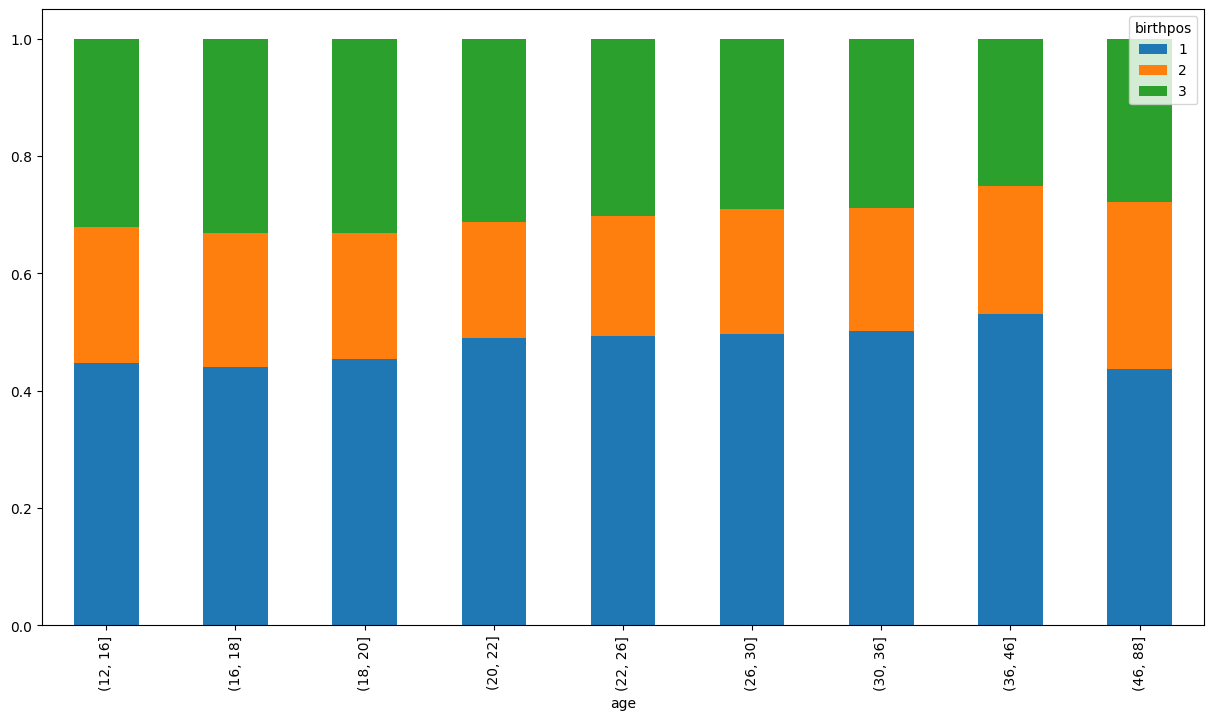

In [39]:
birthorder_abbrev_df = birthorder_df[['age', 'birthpos']]
birthorder_abbrev_df.set_index(pd.cut(
                                  birthorder_abbrev_df['age'],
                                  [12, 16, 18, 20, 22, 26, 30,
                                   36, 46, 88]), inplace=True)
agegroup_birthorder_counts_s = birthorder_abbrev_df.groupby([birthorder_abbrev_df.index,'birthpos']).size()
agegroup_counts_s = birthorder_abbrev_df.groupby(birthorder_abbrev_df.index)['birthpos'].count()
agegroup_pct_birthorder_s = agegroup_birthorder_counts_s.div(agegroup_counts_s,axis=0,level=0)
agegroup_pct_birthorder_s.unstack().plot.bar(stacked=True, figsize=(15,8))

### Interaction PDPs
Create a PDP interaction plot between the features "birth number" and "question Q1" for the random forest model based on the test set.

In [40]:
# Assuming pdpbox is correctly installed and imported
pdp_interact_out = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],
    dataset=X_test,  # Make sure to use only the feature data here
    model_features=X_test.columns.tolist(),
    features=['feature1', 'feature2'],  # Replace with your actual feature names
    n_jobs=-1
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_interact_out, 
    feature_names=['feature1 name', 'feature2 name'],  # Replace with the actual names or labels for the features
    plot_type='grid', 
    x_quantile=True, 
    ncols=2, 
    figsize=(15, 15)
)
plt.show()

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_interact'

In [41]:
pdp_birthn_Q1_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],
    dataset=pd.concat((X_test, y_test), axis=1),
    model_features=..., 
    features=...,
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_birthn_Q1_df,
    plot_type='grid', x_quantile=True,
    ncols=2, figsize=(15,15),
    feature_names=['# of Births','Question #1']
)

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_interact'

#### Now
Create a PDP interaction plot between the features "age" and "time of the test taken by the participant" for the random forest model based on the test set.

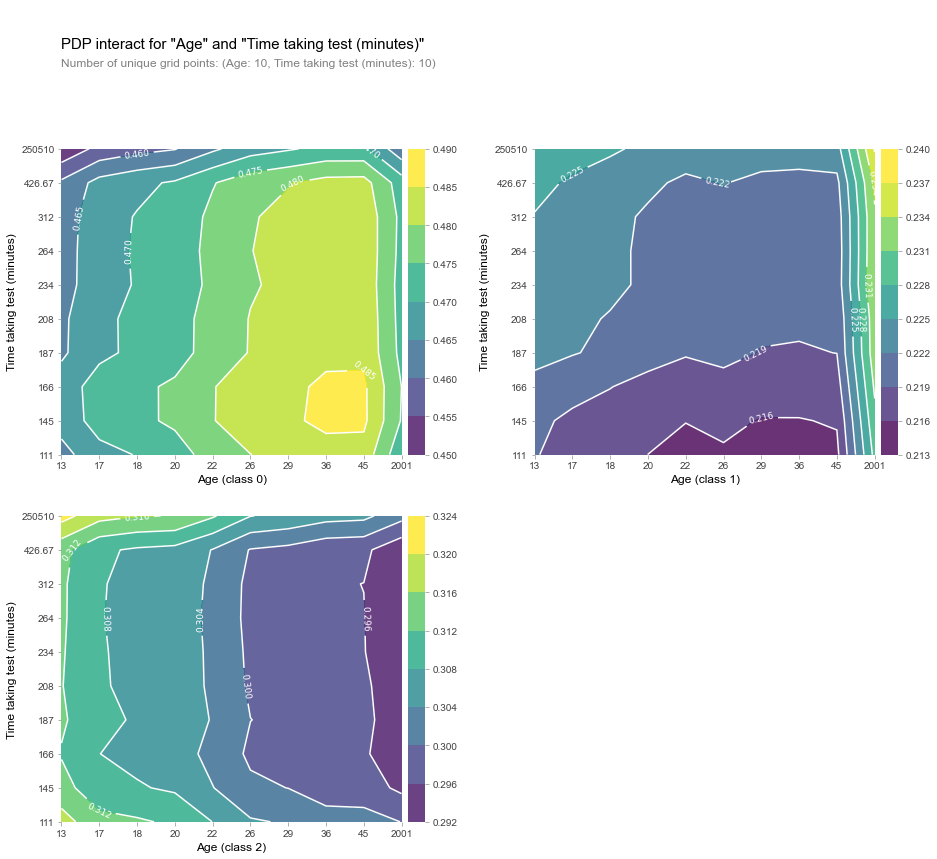

In [ ]:
pdp_age_testelapse_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],
    dataset=...,
    model_features=..., 
    features=...,
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_age_testelapse_df,
    plot_type='contour', x_quantile=True,
    ncols=2, figsize=(15,15),
    feature_names=['Age','Time taking test (minutes)']
)

## Explaining Individual Conditional Expectation (ICE) Plots

ICE plots can include all of the datasets. <br>
But, having many lines in the plots can be computationally expensive & difficult to understand.<br>
Thus, we either subsample the dataset or plot lines with transparency.
#### subsampling the dataset

In [42]:
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(
                    X_test.shape[0],
                    math.ceil(X_test.shape[0]*sample_size),
                    replace=False)
X_test_samp = X_test.iloc[sample_idx,:]

**NB:**<br>
the python ICE implementation uses the function predict by default. <br>
This function is great for regression problems. <br>
But for classification, we would end up with straight lines on top of each other, going toward one of the three possible classes. <br>
Thus, to fix this, we can use predict_proba instead, which returns the predicted probabilities. <br>
Nevertheless, predict_proba returns 3 sets of predicted probabilities that is not understood by the ICE implemenatation. Hence, we create 3 predict functions as follows:

In [43]:
def predict_prob_first_born(test_df):
    return class_models['random_forest']['fitted'].predict_proba(test_df)[:,0]
def predict_prob_middle_child(test_df):
    return class_models['random_forest']['fitted'].predict_proba(test_df)[:,1]
def predict_prob_last_born(test_df):
    return class_models['random_forest']['fitted'].predict_proba(test_df)[:,2]

def plot_data_vs_ice(pred_function, ylabel, X, feature_name, feature_label, color_by=None, legend_key=None, alpha=0.15):
    """
    It computes & plots the ICE plot
    reference: https://pypi.org/project/machine-learning-datasets/0.1.16.4/#files/machine-learning-datasets-0.1.16.4.tar.gz
    """
    ice_df = ice(X, feature_name,
             pred_function, num_grid_points=None)
    fig, axs = plt.subplots(2, 1, sharex=False, sharey=True,
                            figsize=(15,20))
    fig.subplots_adjust(hspace=0.15, wspace=0)
    if color_by is None or legend_key is None:
        scatter = axs[0].scatter(X[feature_name],
                                 pred_function(X),
                                 alpha=alpha)
        ice_plot(ice_df, alpha=alpha, ax=axs[1])
    else:
        scatter = axs[0].scatter(X[feature_name],
                                 pred_function(X),
                                 c=X[color_by], alpha=alpha)
        legend = axs[0].legend(*scatter.legend_elements(), loc='best')
        for s in legend_key.keys(): 
            legend.get_texts()[s].set_text(legend_key[s])
        ice_plot(ice_df, color_by=color_by, alpha=alpha, ax=axs[1])
    axs[0].set_xlabel(feature_label, fontsize=12)
    axs[0].set_ylabel(ylabel, fontsize=12)
    axs[0].set_title('Data', fontsize=16)
    axs[1].set_xlabel(feature_label, fontsize=12)
    axs[1].set_ylabel(ylabel, fontsize=12)
    axs[1].set_title('ICE Curves', fontsize=16)
    plt.show()

In [44]:
legend_key = {0:'N/A', 1:'Disagree', 2:'Somewhat Disagree',
              3:'Neutral', 4:'Somewhat Agree', 5:'Agree'}

### Now
Create an ICE plot of the feature "the number of births" for the first born child using the random forest model based on the subsampled test set.

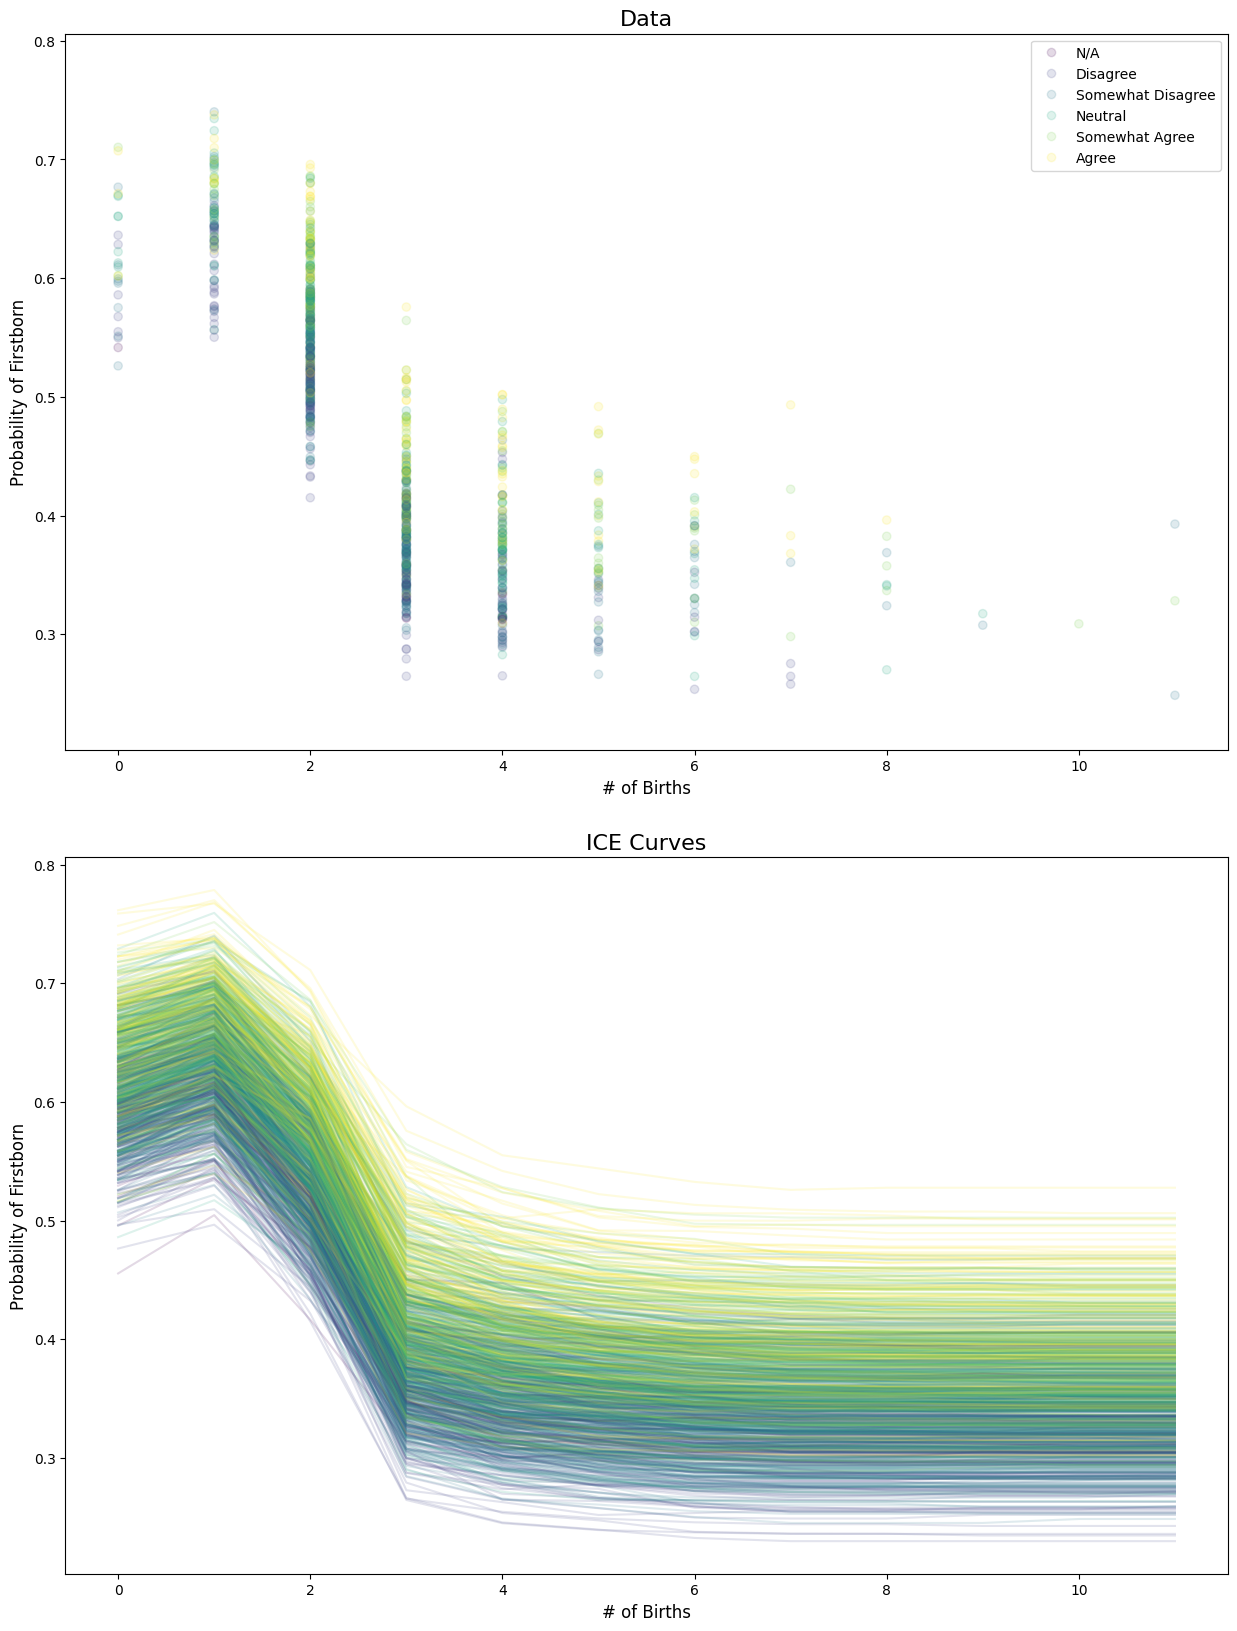

In [45]:
plot_data_vs_ice(pred_function = predict_prob_first_born,
                 ylabel ='Probability of Firstborn',
                 X=X_test_samp,
                 feature_name='birthn',
                 feature_label='# of Births',
                 color_by='Q1', 
                 legend_key=legend_key)

### Now
Create an ICE plot of the feature "the number of births" for the middle child using the random forest model based on the subsampled test set.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


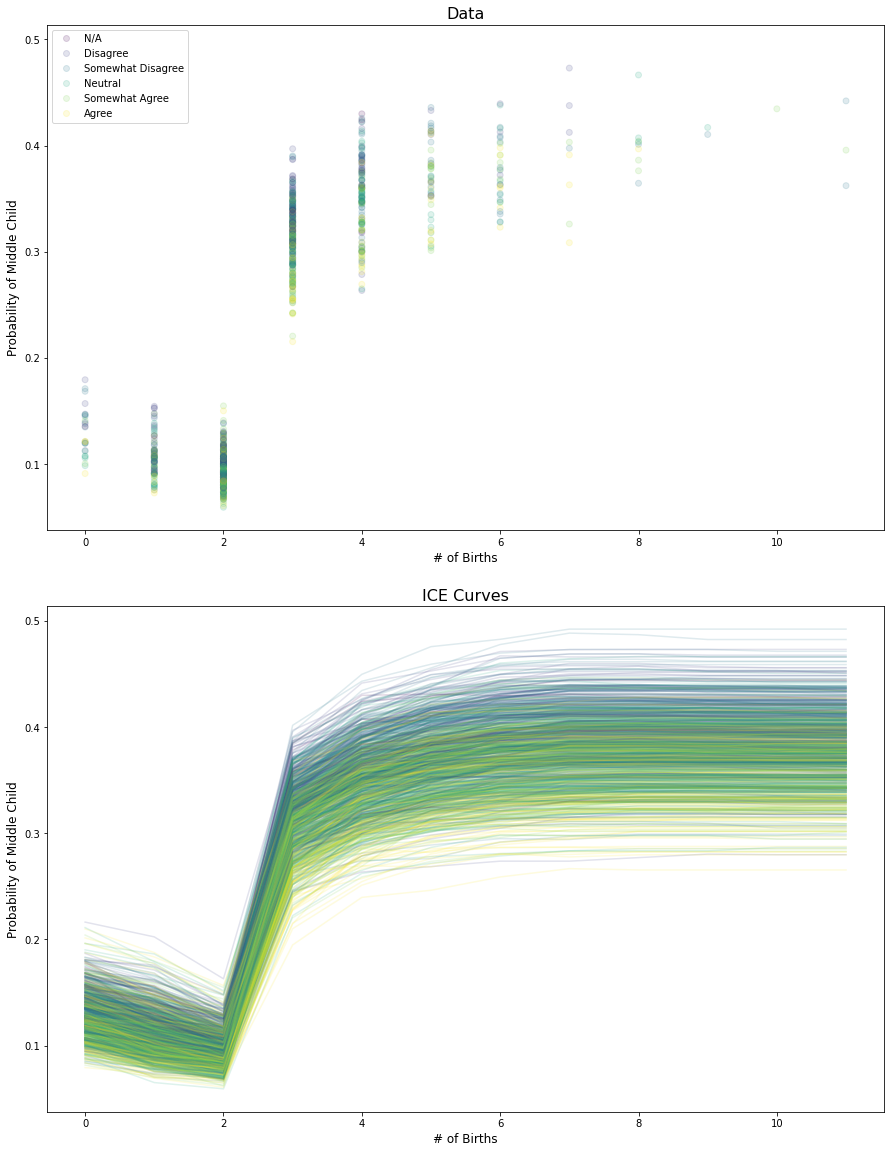

In [159]:
# plot_data_vs_ice(pred_function = predict_prob_first_born,
#                  ylabel ='Probability of Firstborn',
#                  X=X_test_samp,
#                  feature_name='birthn',
#                  feature_label='# of Births',
#                  color_by='Q1', 
#                  legend_key=legend_key)

### Now
Create an ICE plot of the feature "the number of births" for the last born child using the random forest model based on the subsampled test set.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


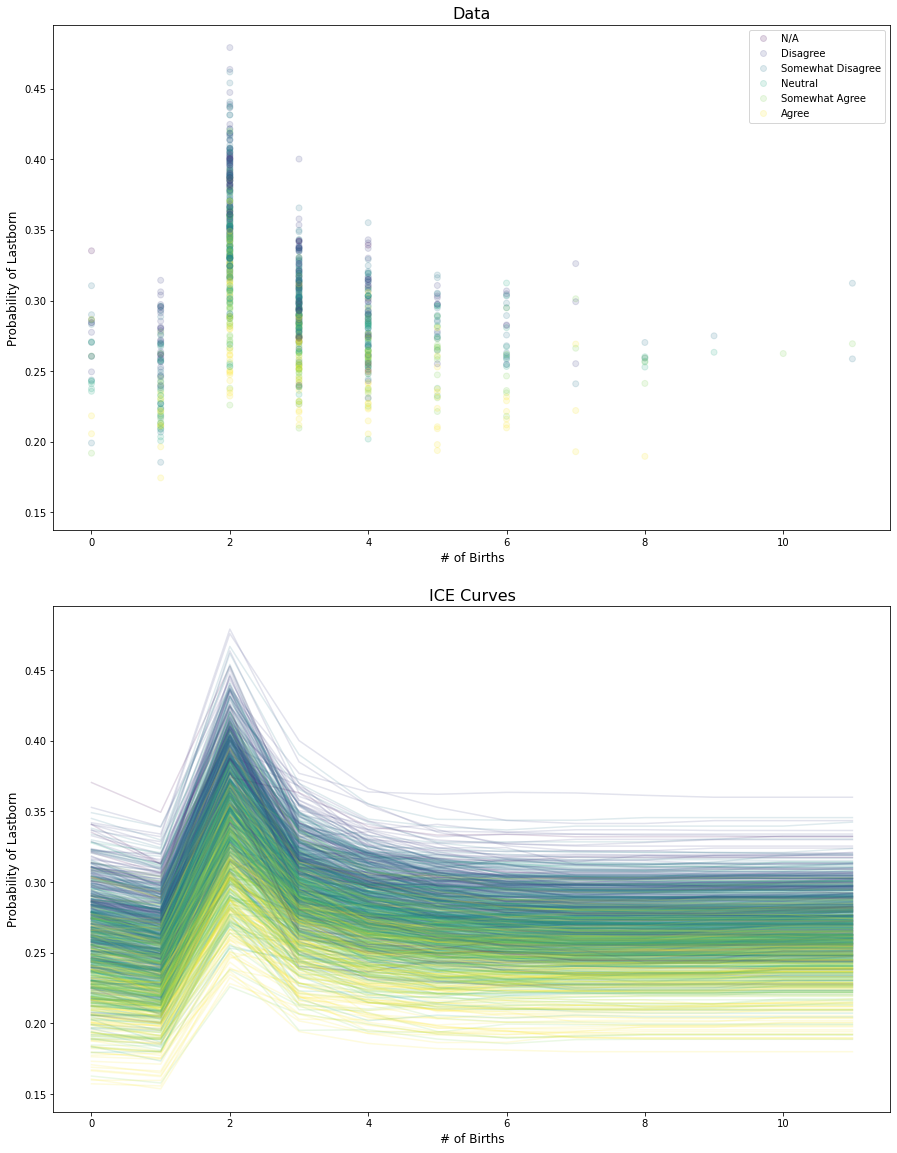

In [160]:
...